In [64]:
from datetime import datetime as dt
from glob import glob as glob
import torch as tr
import numpy as np
import itertools

from Nback_tasks import SerialRecall,NbackTask_PureEM
from Nback_models import PureEM

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size':22})

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- serial recall regression problem
- list of items is presented, same list needs to be returned

- single trial implementation to start

- models needs to use context vector to sort

In [102]:
task = SerialRecall(sedim=2,cedim=2)

In [103]:
t,x,y = task.gen_ep_data(4)


In [109]:
x

tensor([[0.4417, 0.6764],
        [0.9265, 0.1563],
        [0.4980, 0.3004],
        [0.2290, 0.4624]])

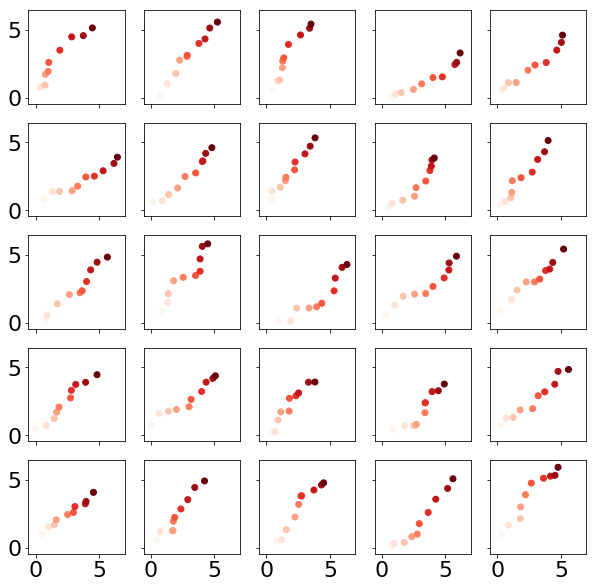

In [185]:
fig,axarr = plt.subplots(5,5,figsize=(10,10),sharex=True,sharey=True)
task = SerialRecall(sedim=2,cedim=2)
for ax in axarr.reshape(-1):
  c,x,y = task.gen_ep_data(10)
  ax.scatter(c[:,0],c[:,1],c=np.arange(len(c))+10,cmap=plt.get_cmap('Reds'))
plt.savefig('figures/serial_recall/sample_cdrift-stim_cumsum')

In [2]:
def run_model(net,gen_data_fn,neps,training=False,verb=False):
  """ gen_data_fn: callable that generates a trial of data (embedded)
  """
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  # data generating option:
  C,X,Y = gen_data_fn()
  seqlen = len(C)
  # loop
  score = -np.ones([neps,seqlen])    
  for ep in range(neps):
    if ep%(neps/10)==0:
      if verb:print(ep/neps)
    # gen stim
    context,stim,ytarget = gen_data_fn()
    # forward prop
    yhat = net(context,stim)
    score[ep] = tr.argmax(tr.softmax(yhat,-1),-1).squeeze() == ytarget
    if training:
      for tstep in range(seqlen):
        loss = lossop(yhat[tstep],ytarget[:,tstep])
        optiop.zero_grad()
        loss.backward(retain_graph=True)
        optiop.step()
  return score



In [3]:
nback=2
ntokens=5
cdrift=0.5
cdim=5
sedim=10
indim=cdim+sedim
stsize=20

task = NbackTask_PureEM(nback=nback,ntokens=ntokens,cdrift=.5,cdim=5,sedim=10)
net = PureEM(nback,indim,stsize,mthresh=.95,seed=132,debug=False)

In [4]:
neps = 2000
seqlen = 10

gen_rand_trials = lambda: task.gen_ep_data(seqlen)
trsc = run_model(net,gen_rand_trials,neps,training=True,verb=False)

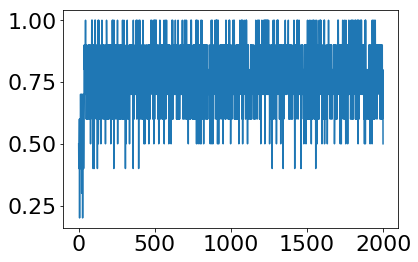

In [5]:
plt.plot(trsc.mean(1))

In [6]:
evsc = run_model(net,gen_rand_trials,500,training=False,verb=False)

(0.5, 1)

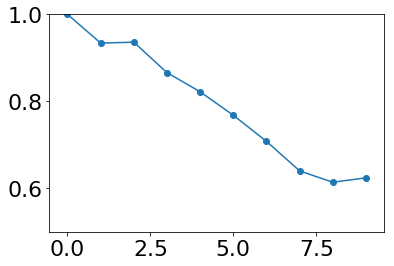

In [7]:
M = evsc.mean(0)
plt.plot(M)
plt.scatter(range(len(M)),M)
plt.ylim(0.5,1)

In [8]:
seqlen=10
evsc = run_model(net,gen_rand_trials,1,training=False,verb=False)